# Heatmap Visualization
 ## code for Figure 2D-E,Figure S2, S4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import math


In [2]:
def parcel_to_network_edge(avg_corr,network,network_size=17):
    #convert [n_parc x n_parc] matrix to [n_network x n_network] matrix
    
    network_corr = np.zeros([network_size,network_size])
    for i in range(network_size):
        for j in range(network_size):
            parcs_ls1=np.where(network_list==i+1)
            parcs_ls2=np.where(network_list==j+1)
            current_net=avg_corr[parcs_ls1][:,parcs_ls2]
            
            network_corr[i,j]=np.sum(current_net)
    return network_corr

In [3]:
from scipy.stats import hypergeom

def fast_hypergeom_pmf(N, A, n, x):
    return hypergeom.pmf(x, N, A, n)

def fast_hypergeom_cdf(N, A, n, t, min_value=None):
    if min_value is not None:
        return hypergeom.cdf(t, N, A, n) - hypergeom.cdf(min_value - 1, N, A, n)
    return hypergeom.cdf(t, N, A, n)

In [4]:
def combine_matrix(cort_m,plac_m):
    if isinstance(cort_m[0,0],str):
        data_plot=np.full((11,11),'                  ')
    else:
        data_plot=np.zeros((11,11))
    mask_up = np.zeros_like(data_plot, dtype=bool)
    mask_up[np.triu_indices_from(mask_up)] = True

    mask_lower = np.zeros_like(data_plot, dtype=bool)
    mask_lower[np.tril_indices_from(mask_lower)] = True

    mask_up1 = np.zeros_like(cort_m, dtype=bool)
    mask_up1[np.triu_indices_from(mask_up1)] = True

    mask_lower1 = np.zeros_like(cort_m, dtype=bool)
    mask_lower1[np.tril_indices_from(mask_lower1)] = True
    data_plot[~mask_up]=cort_m[mask_lower1]
    data_plot[~mask_lower]=plac_m[mask_up1]
    np.fill_diagonal(data_plot,np.nan)
    return data_plot,mask_lower,mask_up

In [5]:
def calculate_significance(network_edges, network, total_edges, total_network, network_name):
    """Calculate significance metrics for network edges."""
    pvalues = np.full((10, 10), '           ')
    results = []
    
    for i in range(len(network)):
        for j in range(len(network)):
            p = 1 - fast_hypergeom_cdf(
                total_edges,
                int(total_network[i,j]/2),
                network_edges,
                int(network[i,j]/2)
            )
            
            # Store significance markers
            if p < 0.001: 
                pvalues[i,j] = "***"
            elif p < 0.01: 
                pvalues[i,j] = "**"
            elif p < 0.05: 
                pvalues[i,j] = "*"
            
            results.append({
                'netA': network_name[i],
                'netB': network_name[j],
                'pvalue': p,
                'percentage': network[i,j]
            })
            
    return pvalues, results

def create_heatmap(cort_data, plac_data, pvalues, title, output_path, network_labels, show_annot=True):
    """Create and save network heatmap."""
    data_plot, mask_lower, mask_up = combine_matrix(cort_data, plac_data)
    annot_text, _, _ = combine_matrix(pvalues['cortisol'], pvalues['placebo'])
    
    data_plot = pd.DataFrame(
        data_plot,
        index=[np.nan] + network_labels,
        columns=network_labels + [np.nan]
    )
    
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.set(font_scale=1, style="white")
    
    kws = {'fontsize': 15, 'color': 'black', 'va': 'center', 'ha': 'center'}
    
    # Plot cortisol data
    max_cort = np.max(cort_data)
    max_cort = np.ceil(max_cort * 10) / 10 if max_cort > 0 else max_cort
    
    sns.heatmap(
        data_plot,
        vmax=max_cort,
        annot=annot_text if show_annot else False,
        fmt="",
        annot_kws=kws,
        mask=~mask_lower,
        cmap=sns.color_palette("light:#e06545", as_cmap=True),
        cbar_kws={'label': 'Cortisol Edges Percentage'},
        square=True
    )
    
    # Plot placebo data
    max_plac = np.max(plac_data)
    max_plac = np.ceil(max_plac * 10) / 10 if max_plac > 0 else max_plac
    
    sns.heatmap(
        data_plot,
        vmax=max_plac,
        annot=annot_text if show_annot else False,
        fmt="",
        annot_kws=kws,
        mask=~mask_up,
        cmap=sns.color_palette("light:#b44582", as_cmap=True),
        square=True,
        cbar_kws={'label': 'Placebo Edges Percentage'}
    )
    
    ax.grid(False)
    plt.title(title)
    fig.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()


In [6]:
edges=np.ones([377,377])
np.fill_diagonal(edges,0)
network_list=scipy.io.loadmat("data/atlas_info/network_defs_377node.mat")
network_list=network_list['networkInfo'][0]
total_network=parcel_to_network_edge(edges,network_list,network_size=10)

total_edges=70876
network_name=['medfront', 'frontoparietal', 'DMN', 'motor', 'visA', 'visB',
    'visassoc', 'salience', 'subcort', 'cerebell']
network_size=10


# plot anatomy for individual networks

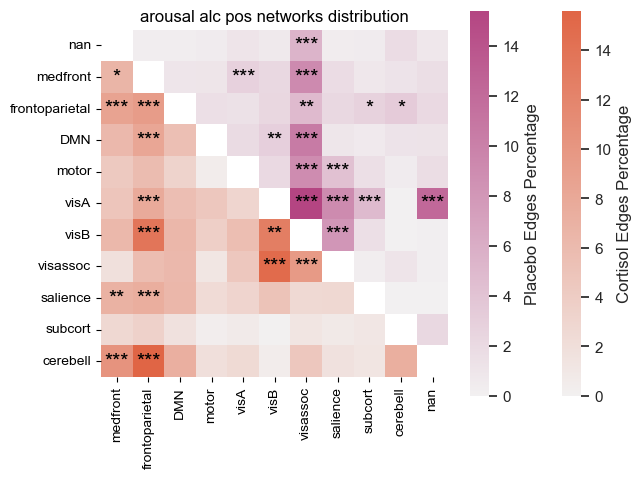

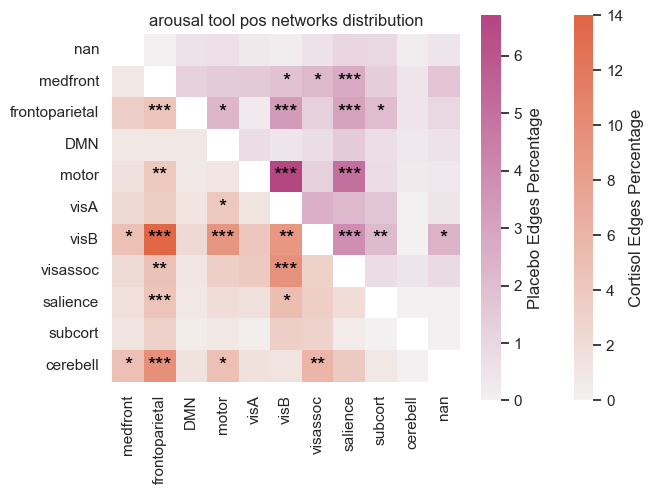

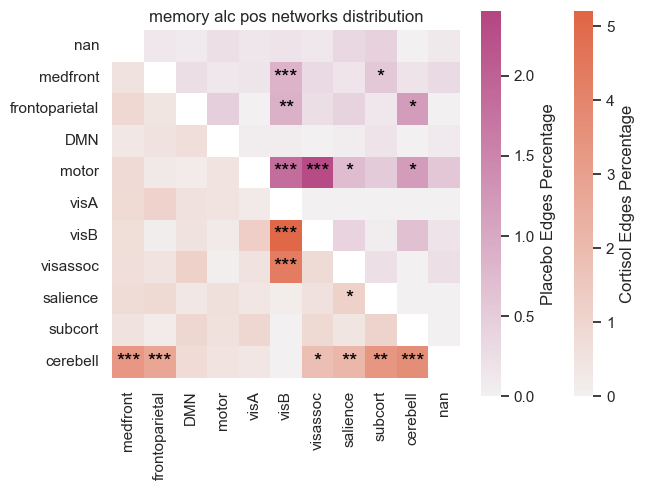

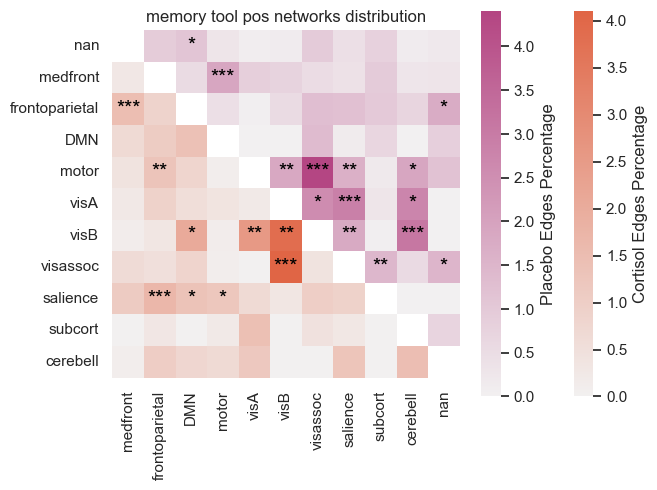

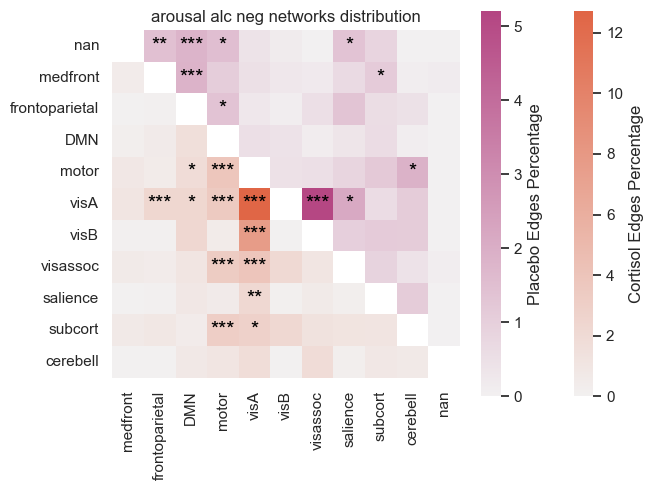

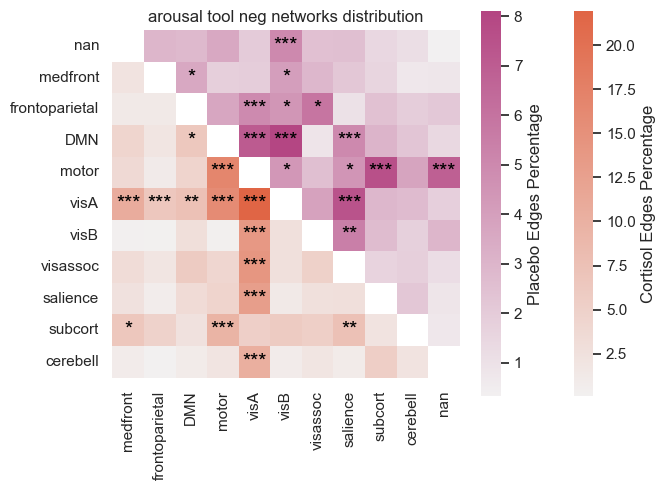

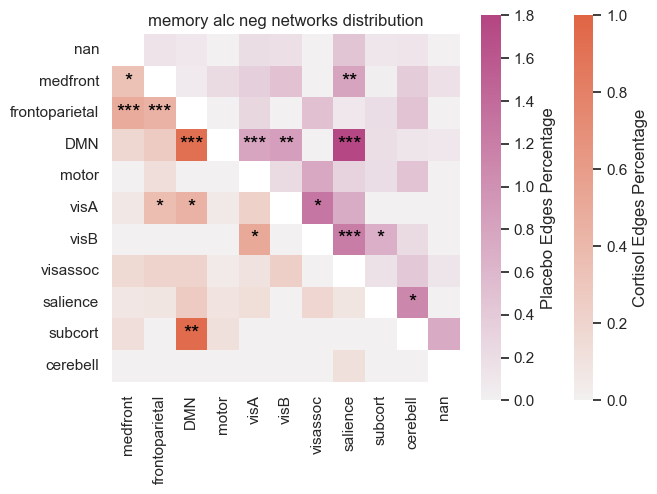

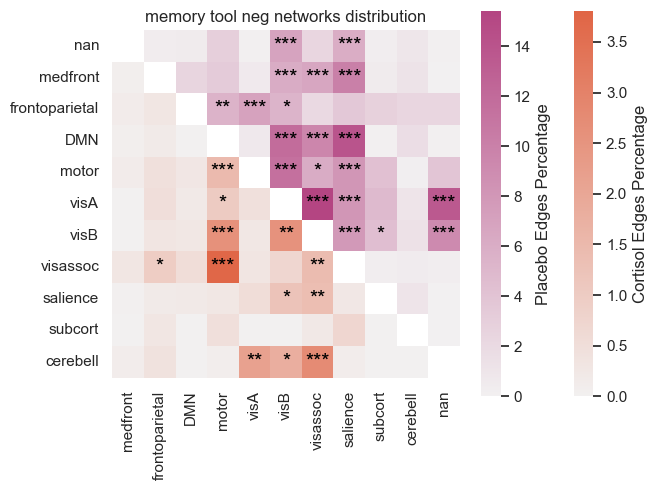

In [7]:
def analyze_networks(pheno_list, conditions, base_path, network_list, network_name, total_network, total_edges):
    """Analyze and plot regular network data."""
    network_labels = ['medfront', 'frontoparietal', 'DMN', 'motor', 'visA', 'visB',
                     'visassoc', 'salience', 'subcort', 'cerebell']
    
    all_results = []
    
    for sign in ['pos', 'neg']:
        for pheno in pheno_list:
            for condition in conditions:
                # Load and process data
                if pheno == "arousal":
                    name = "Arous_All"
                else:
                    name = "RecogAcc_coded"
                cort_edges = pd.read_csv(
                    f'{base_path}n26_{name}_byTrial_cortisol_{condition}_htBPfiltered_p0.01_{sign}.txt',
                    header=None
                ).values
                plac_edges = pd.read_csv(
                    f'{base_path}n26_{name}_byTrial_placebo_{condition}_htBPfiltered_p0.01_{sign}.txt',
                    header=None
                ).values
                
                # Calculate metrics
                cort_network=parcel_to_network_edge(cort_edges,network_list,network_size=10)
                cort_network_plot=cort_network/total_network*100
                
                plac_network=parcel_to_network_edge(plac_edges,network_list,network_size=10)
                plac_network_plot=plac_network/total_network*100
                
                # Calculate significance
                cort_pvals, cort_results = calculate_significance(
                    int(np.sum(cort_edges)/2), cort_network,
                    total_edges, total_network, network_name
                )
                plac_pvals, plac_results = calculate_significance(
                    int(np.sum(plac_edges)/2), plac_network,
                    total_edges, total_network, network_name
                )
                
                # Store results
                for results, pill in [(cort_results, 'cortisol'), (plac_results, 'placebo')]:
                    for result in results:
                        result.update({
                            'behavior': pheno,
                            'condition': condition,
                            'pill': pill,
                            'sign': sign
                        })
                        all_results.append(result)
                
                # Create and save plot
                create_heatmap(
                    cort_network_plot,
                    plac_network_plot,
                    {'cortisol': cort_pvals, 'placebo': plac_pvals},
                    f'{pheno} {condition} {sign} networks distribution',
                    f"plots/{pheno}_{condition}_{sign}_network_percentage_heatmap.pdf",
                    network_labels
                )
    
    # Save results
    pd.DataFrame(all_results).to_csv(
        'results/network_anatomy/network_anatomy_summary.csv',
        index=False
    )


# Usage
pheno_list = ['arousal','memory'] 
conditions = ['alc','tool']

# Run both analyses
analyze_networks(pheno_list, conditions, 'CPM code/result/network_edges/',
                network_list, network_name, total_network, total_edges)


# plot anatomy for overlap networks

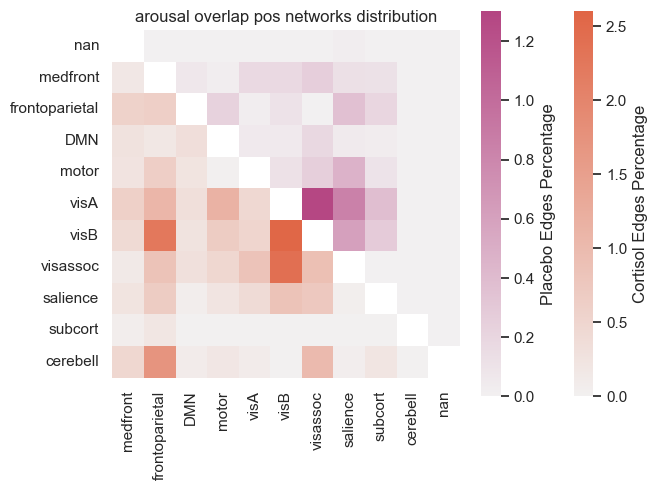

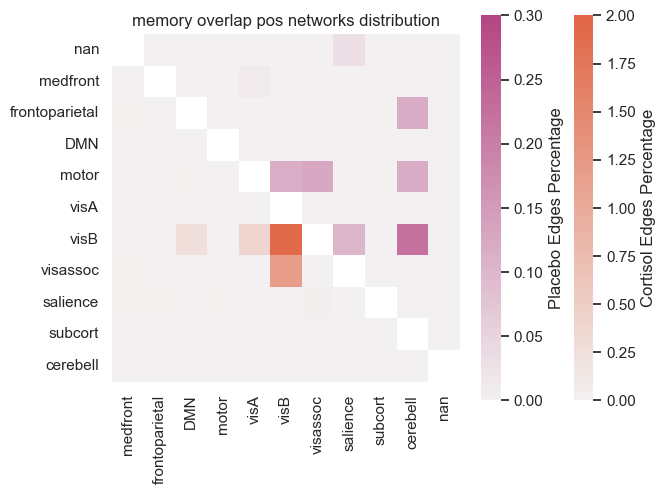

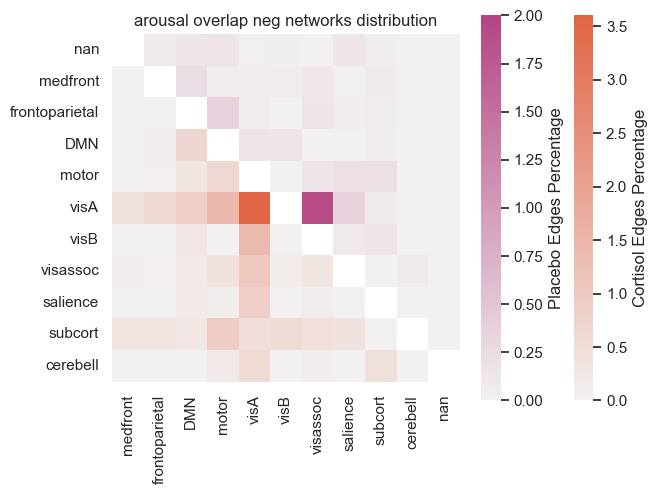

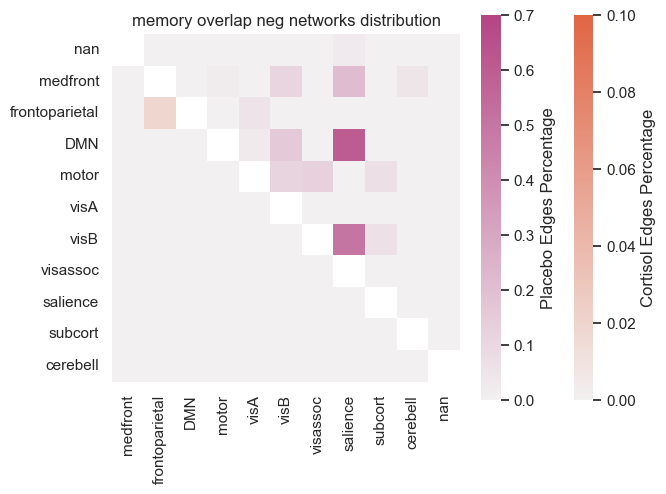

In [8]:
def analyze_network_overlap(pheno_list, network_list, network_name, total_network, total_edges):
    """Analyze and plot network overlap data."""
    network_labels = ['medfront', 'frontoparietal', 'DMN', 'motor', 'visA', 'visB',
                     'visassoc', 'salience', 'subcort', 'cerebell']
    
    all_results = []
    
    for sign in ['pos', 'neg']:
        for pheno in pheno_list:
            # Load overlap data
            cort_edges = pd.read_csv(
                f'results/network_overlap/{pheno}_cortisol_alc_{sign}&cortisol_tool_{sign}_overlap.txt',
                header=None
            ).values
            plac_edges = pd.read_csv(
                f'results/network_overlap/{pheno}_placebo_alc_{sign}&placebo_tool_{sign}_overlap.txt',
                header=None
            ).values
            
            # Calculate metrics
            cort_network=parcel_to_network_edge(cort_edges,network_list,network_size=10)
            cort_network_plot=cort_network/total_network*100
            
            plac_network=parcel_to_network_edge(plac_edges,network_list,network_size=10)
            plac_network_plot=plac_network/total_network*100
            
            # Calculate significance
            cort_pvals, cort_results = calculate_significance(
                int(np.sum(cort_edges)/2), cort_network,
                total_edges, total_network, network_name
            )
            plac_pvals, plac_results = calculate_significance(
                int(np.sum(plac_edges)/2), plac_network,
                total_edges, total_network, network_name
            )
            
            # Store results
            for results, pill in [(cort_results, 'cortisol'), (plac_results, 'placebo')]:
                for result in results:
                    result.update({
                        'behavior': pheno,
                        'pill': pill,
                        'sign': sign
                    })
                    all_results.append(result)
            
            # Create and save plot
            create_heatmap(
                cort_network_plot,
                plac_network_plot,
                {'cortisol': cort_pvals, 'placebo': plac_pvals},
                f'{pheno} overlap {sign} networks distribution',
                f"plots/{pheno}_{sign}_overlap_network_percentage_heatmap.pdf",
                network_labels,
                show_annot=False 
            )
    
    # Save results
    pd.DataFrame(all_results).to_csv(
        'results/network_overlap/network_run_overlap_anatomy_summary.csv',
        index=False
    )
pheno_list = ['arousal', 'memory'] 
conditions = ['alc', 'tool']
analyze_network_overlap(pheno_list, network_list, network_name, total_network, total_edges)

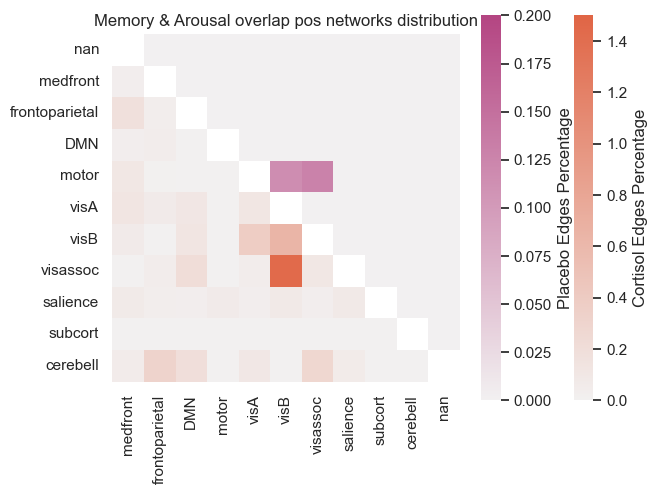

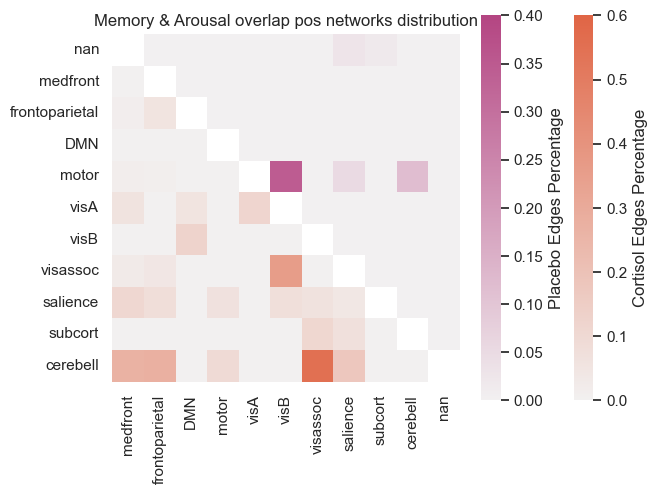

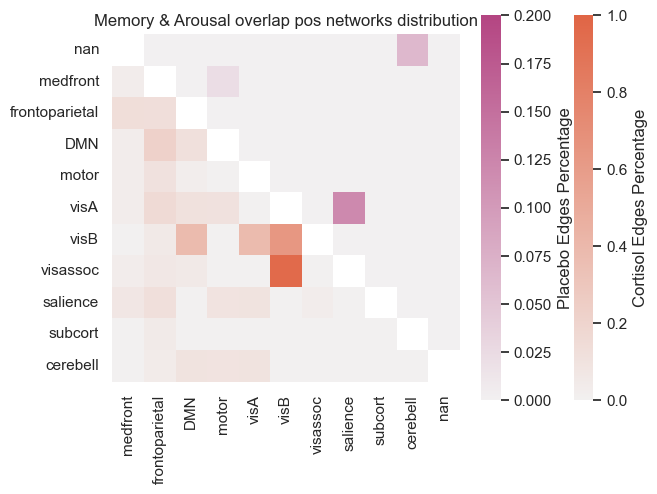

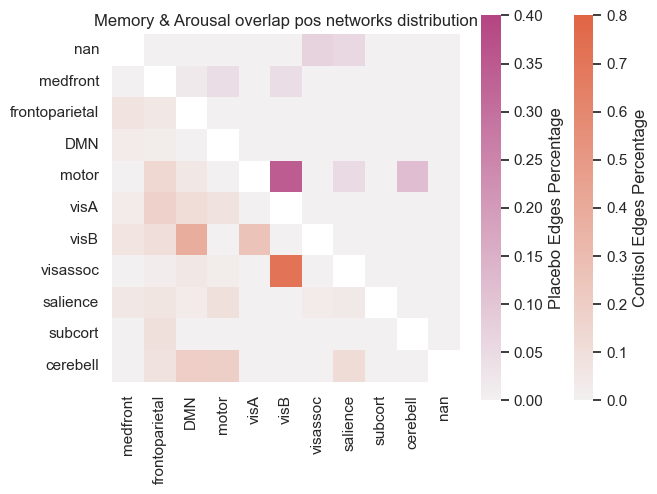

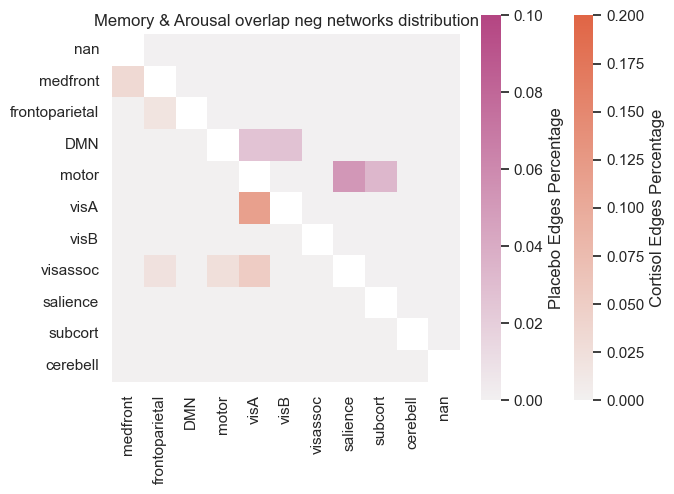

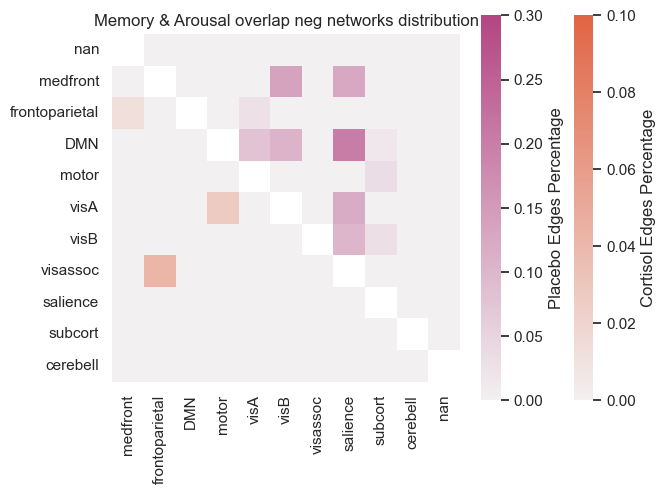

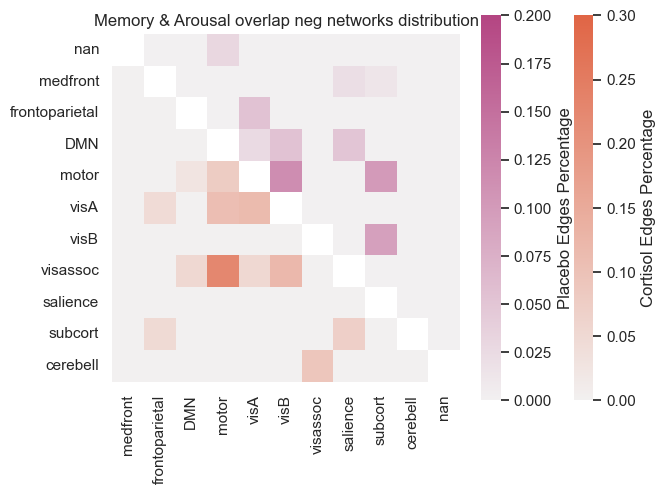

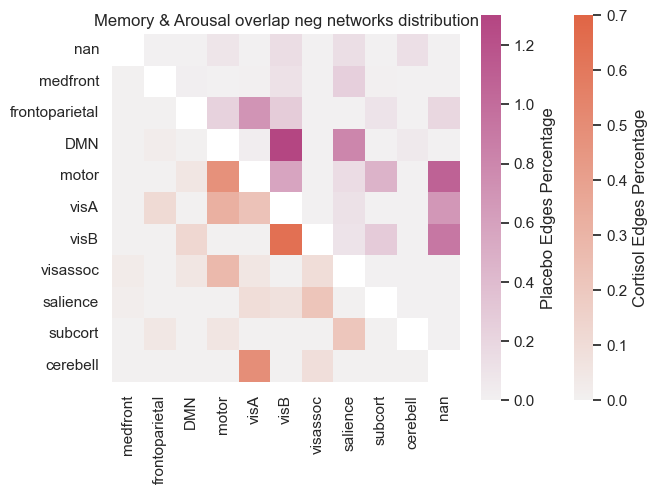

In [9]:
def analyze_memory_arousal_overlap(network_list, network_name, total_network, total_edges):
    """Analyze and plot memory and arousal network overlap data."""
    network_labels = ['medfront', 'frontoparietal', 'DMN', 'motor', 'visA', 'visB',
                     'visassoc', 'salience', 'subcort', 'cerebell']
    
    all_results = []
    
    for sign in ['pos', 'neg']:
        for stim1 in ['alc', 'tool']:
            for stim2 in ['alc', 'tool']:
                # Load overlap data
                cort_edges = pd.read_csv(
                    f'results/network_overlap/memory_cortisol_{stim1}_{sign}&arousal_cortisol_{stim2}_{sign}_overlap.txt',
                    header=None
                ).values
                plac_edges = pd.read_csv(
                    f'results/network_overlap/memory_placebo_{stim1}_{sign}&arousal_placebo_{stim2}_{sign}_overlap.txt',
                    header=None
                ).values
                
                # Calculate metrics
                cort_network=parcel_to_network_edge(cort_edges,network_list,network_size=10)
                cort_network_plot=cort_network/total_network*100
                
                plac_network=parcel_to_network_edge(plac_edges,network_list,network_size=10)
                plac_network_plot=plac_network/total_network*100
                
                # Calculate significance
                cort_pvals, cort_results = calculate_significance(
                    int(np.sum(cort_edges)/2), cort_network,
                    total_edges, total_network, network_name
                )
                plac_pvals, plac_results = calculate_significance(
                    int(np.sum(plac_edges)/2), plac_network,
                    total_edges, total_network, network_name
                )
                
                # Store results
                for results, pill in [(cort_results, 'cortisol'), (plac_results, 'placebo')]:
                    for result in results:
                        result.update({
                            'stim1': stim1,
                            'stim2': stim2,
                            'pill': pill,
                            'sign': sign
                        })
                        all_results.append(result)
                
                # Create and save plot
                create_heatmap(
                    cort_network_plot,
                    plac_network_plot,
                    {'cortisol': cort_pvals, 'placebo': plac_pvals},
                    f'Memory & Arousal overlap {sign} networks distribution',
                    f"plots/memory_{stim1}_arousal_{stim2}_{sign}_overlap_network_percentage_heatmap.pdf",
                    network_labels,
                    show_annot=False
                )
    
    # Save results
    pd.DataFrame(all_results).to_csv(
        'results/network_overlap/memory_arousal_network_overlap_summary.csv',
        index=False
    )

# Execute the analysis
analyze_memory_arousal_overlap(network_list, network_name, total_network, total_edges)